# SEMMA — UCI Bank Marketing (Term Deposit Subscription)
.


## 
**Goal:** Build representative train/validation/test splits with stratification. Optionally take a smaller design sample for rapid iteration.

In [4]:
!pip -q install pandas numpy scikit-learn matplotlib ucimlrepo --quiet

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

# fetch dataset (UCI Bank Marketing)
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas DataFrames)
X = bank_marketing.data.features.copy()
y_raw = bank_marketing.data.targets.copy()

# ensure binary target y as int {yes:1, no:0}
target_col = 'y' if 'y' in y_raw.columns else y_raw.columns[0]
y = y_raw[target_col].map({'yes': 1, 'no': 0}).astype(int)

# metadata & variable info
print(bank_marketing.metadata)
print(bank_marketing.variables.head() if hasattr(bank_marketing, "variables") else "No variable details available.")

# stratified Train/Valid/Test splits: 60/20/20
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)

# optional design sample for quicker iteration (50% of train)
design_frac = 0.5
X_train_design, _, y_train_design, _ = train_test_split(
    X_train, y_train, test_size=1 - design_frac, stratify=y_train, random_state=42
)

print("Target rate =", round(float(y.mean()), 4))
print("Shapes:", X_train.shape, X_valid.shape, X_test.shape, X_train_design.shape)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

## E — Explore
Summaries, missingness, and simple target relationships.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,27126.0,NaN,NaN,NaN,40.894382,10.632995,18.0,33.0,39.0,48.0,95.0
job,26947,11,blue-collar,5814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,27126,3,married,16286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,26026,3,secondary,13965,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,27126,2,no,26629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,27126.0,NaN,NaN,NaN,1368.13312,3087.753667,-6847.0,73.0,454.0,1425.75,81204.0
housing,27126,2,yes,15150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,27126,2,no,22723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,19336,2,cellular,17595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,27126.0,NaN,NaN,NaN,15.800597,8.323448,1.0,8.0,16.0,21.0,31.0


Missingness (top 15)
poutcome       0.819878
contact        0.287178
education      0.040552
job            0.006599
default        0.000000
balance        0.000000
age            0.000000
marital        0.000000
loan           0.000000
housing        0.000000
month          0.000000
day_of_week    0.000000
duration       0.000000
campaign       0.000000
pdays          0.000000
dtype: float64


<Figure size 640x480 with 0 Axes>

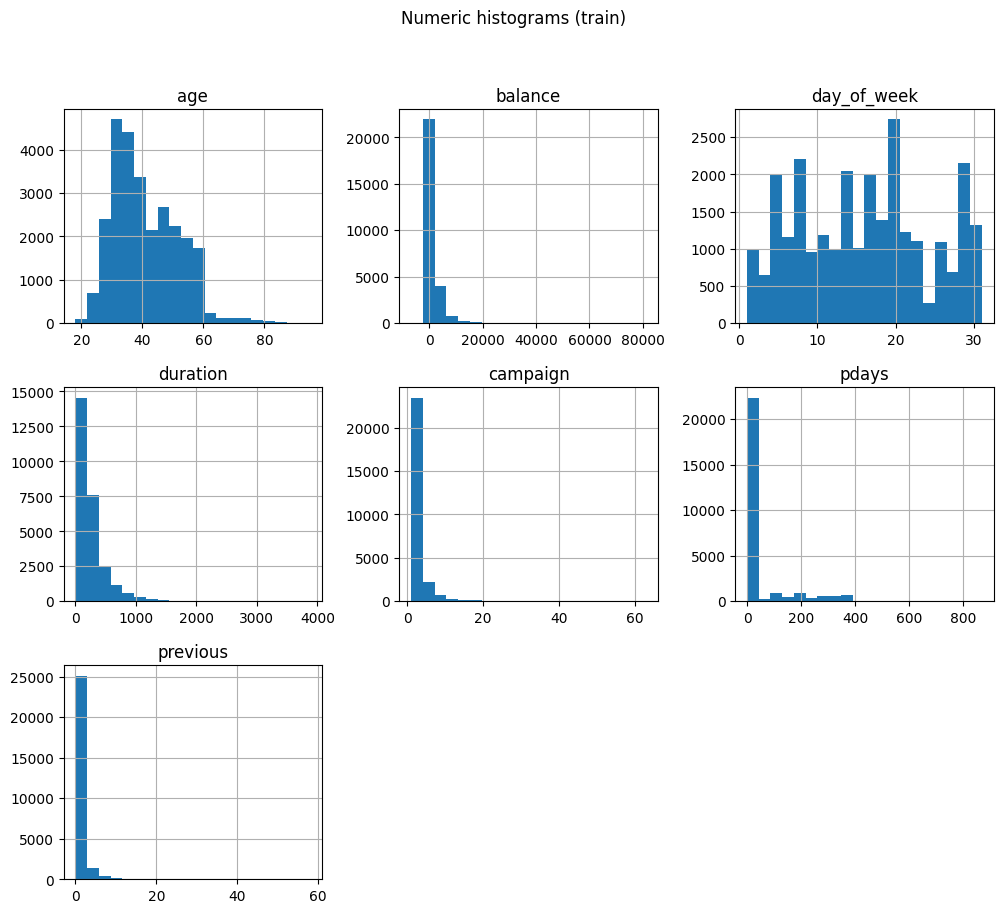

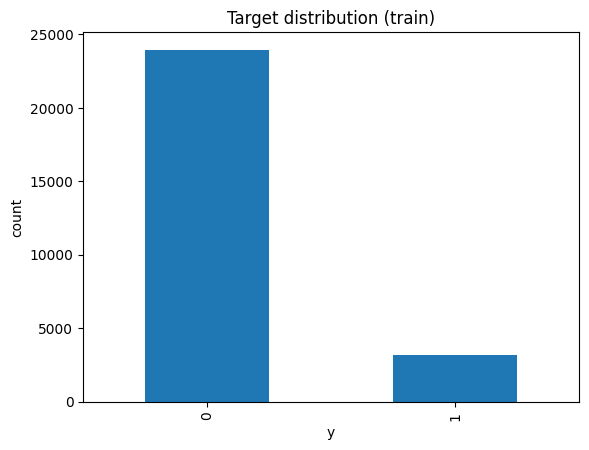

In [5]:

df_info = X_train.describe(include='all').T
display(df_info.head(15))

missing = X_train.isna().mean().sort_values(ascending=False)
print('Missingness (top 15)'); print(missing.head(15))

num_cols = X_train.select_dtypes(include=[np.number]).columns
plt.figure(); X_train[num_cols].hist(bins=20, figsize=(12,10)); plt.suptitle('Numeric histograms (train)'); plt.show()

plt.figure(); y_train.value_counts().sort_index().plot(kind='bar'); plt.title('Target distribution (train)'); plt.xlabel('y'); plt.ylabel('count'); plt.show()


In [6]:

cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
def target_rate_by(col):
    t = pd.crosstab(X_train[col], y_train, normalize='index').rename(columns={0:'rate_no',1:'rate_yes'})
    t['count'] = X_train[col].value_counts()
    return t.sort_values('rate_yes', ascending=False).head(10)
for c in cat_cols[:5]:
    print(f"\nTop levels for {c}:"); display(target_rate_by(c))



Top levels for job:


y,rate_no,rate_yes,count
job,,,
student,0.712522,0.287478,567
retired,0.772561,0.227439,1363
unemployed,0.848524,0.151476,779
management,0.858956,0.141044,5594
admin.,0.877499,0.122501,3151
self-employed,0.878594,0.121406,939
technician,0.892787,0.107213,4561
entrepreneur,0.899662,0.100338,887
services,0.911800,0.088200,2517



Top levels for marital:


y,rate_no,rate_yes,count
marital,,,
single,0.851425,0.148575,7720
divorced,0.875000,0.125000,3120
married,0.899546,0.100454,16286



Top levels for education:


y,rate_no,rate_yes,count
education,,,
tertiary,0.849049,0.150951,7943
secondary,0.895023,0.104977,13965
primary,0.913550,0.086450,4118



Top levels for default:


y,rate_no,rate_yes,count
default,,,
no,0.881896,0.118104,26629
yes,0.943662,0.056338,497



Top levels for housing:


y,rate_no,rate_yes,count
housing,,,
no,0.833417,0.166583,11976
yes,0.922244,0.077756,15150


## M — Modify
Reproducible preprocessing: impute, encode, transform.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# candidate columns to log-transform
skew_candidates = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
skew_indices = [numeric_cols.index(c) for c in skew_candidates if c in numeric_cols]
pdays_index = numeric_cols.index('pdays') if 'pdays' in numeric_cols else -1  # get index

def log1p_selected_numpy(X):
    X_out = X.astype(float).copy()

    # Replace invalid 'pdays' sentinel values (-1) with NaN
    if pdays_index != -1:
        X_out[:, pdays_index][X_out[:, pdays_index] == -1] = np.nan

    # Apply safe log1p transformation
    for i in skew_indices:
        col = X_out[:, i]
        # Replace nonpositive numbers (<= -1) with 0 to avoid log errors
        col = np.where(col <= -1, 0, col)
        with np.errstate(divide='ignore', invalid='ignore'):
            col = np.log1p(col)
        # Replace any inf/nan with 0 afterward
        col[~np.isfinite(col)] = 0
        X_out[:, i] = col

    return X_out

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),       # impute first
    ('log1p', FunctionTransformer(func=log1p_selected_numpy, validate=False)),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, numeric_cols),
    ('cat', categorical_pipe, categorical_cols)
], remainder='drop')

# fit-transform
Xtr = preprocess.fit_transform(X_train, y_train)
Xva = preprocess.transform(X_valid)
Xte = preprocess.transform(X_test)

print(Xtr.shape, Xva.shape, Xte.shape)


(27126, 47) (9042, 47) (9043, 47)


## M — Model
Train candidate models with CV; handle imbalance via class_weight.

In [15]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

def fit_and_eval(model, param_grid, name):
    pipe = Pipeline([('prep', preprocess), ('clf', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    search.fit(X_train, y_train)
    best = search.best_estimator_
    proba = best.predict_proba(X_valid)[:,1]
    roc = roc_auc_score(y_valid, proba)
    ap = average_precision_score(y_valid, proba)
    print(f"\n{name} — ROC-AUC(Valid): {roc:.3f}, AP: {ap:.3f}")
    return best, proba, {'roc_auc': roc, 'ap': ap}

results = {}

lr_model, lr_proba, lr_metrics = fit_and_eval(
    LogisticRegression(max_iter=2000, class_weight='balanced'),
    {'clf__C':[0.25,0.5,1.0,2.0], 'clf__solver':['lbfgs']}, 'Logistic Regression')
results['LogReg'] = lr_metrics

rf_model, rf_proba, rf_metrics = fit_and_eval(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    {'clf__n_estimators':[300,600], 'clf__max_depth':[None,10,16], 'clf__min_samples_leaf':[1,3,5]}, 'Random Forest')
results['RandomForest'] = rf_metrics

hgb_model, hgb_proba, hgb_metrics = fit_and_eval(
    HistGradientBoostingClassifier(random_state=42, max_bins=255, learning_rate=0.1),
    {'clf__max_depth':[None,3,6], 'clf__learning_rate':[0.05,0.1,0.2]}, 'HistGradientBoosting')
results['HGB'] = hgb_metrics

results



Logistic Regression — ROC-AUC(Valid): 0.904, AP: 0.553

Random Forest — ROC-AUC(Valid): 0.926, AP: 0.611

HistGradientBoosting — ROC-AUC(Valid): 0.930, AP: 0.627


{'LogReg': {'roc_auc': np.float64(0.9041197944092344),
  'ap': np.float64(0.553335464368285)},
 'RandomForest': {'roc_auc': np.float64(0.9258432981274458),
  'ap': np.float64(0.610655945654669)},
 'HGB': {'roc_auc': np.float64(0.930213037132867),
  'ap': np.float64(0.6272844147806733)}}

## A — Assess
Calibrate, choose a threshold by policy/utility, compute lift and KS, and finalize metrics on **test**.

Selected best (valid ROC): HGB {'roc_auc': np.float64(0.930213037132867), 'ap': np.float64(0.6272844147806733)}
Test — ROC-AUC: 0.926, AP: 0.615, Brier: 0.064
Confusion matrix @ top-15% policy:
 [[7375  610]
 [ 311  747]]

Classification report:
               precision    recall  f1-score   support

           0      0.960     0.924     0.941      7985
           1      0.550     0.706     0.619      1058

    accuracy                          0.898      9043
   macro avg      0.755     0.815     0.780      9043
weighted avg      0.912     0.898     0.903      9043



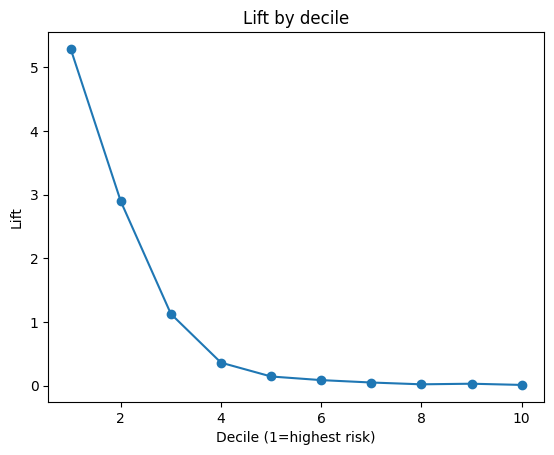

KS statistic: 0.73


In [16]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, precision_recall_curve, confusion_matrix, classification_report
import numpy as np, matplotlib.pyplot as plt

best_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = {'LogReg': lr_model, 'RandomForest': rf_model, 'HGB': hgb_model}[best_name]
print('Selected best (valid ROC):', best_name, results[best_name])

calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)
proba_test = calibrated.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
brier = brier_score_loss(y_test, proba_test)
print(f"Test — ROC-AUC: {roc:.3f}, AP: {ap:.3f}, Brier: {brier:.3f}")

# Policy: act on top 15% highest risk
top_frac = 0.15
k = int(np.ceil(top_frac*len(proba_test)))
thr_topk = np.sort(proba_test)[-k] if k>0 else 1.0
y_pred = (proba_test >= thr_topk).astype(int)

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix @ top-15% policy:\n', cm)
print('\nClassification report:\n', classification_report(y_test, y_pred, digits=3))

# Lift by decile
def lift_curve(p, y, buckets=10):
    df_eval = pd.DataFrame({'p':p, 'y':y}).sort_values('p', ascending=False)
    df_eval['bucket'] = pd.qcut(df_eval['p'], q=buckets, labels=False, duplicates='drop')
    gains = df_eval.groupby('bucket')['y'].mean().sort_index(ascending=False)
    baseline = y.mean()
    lift = gains / baseline
    return gains.values, lift.values, baseline

g, l, base = lift_curve(proba_test, y_test, buckets=10)
plt.figure(); plt.plot(range(1,len(l)+1), l, marker='o'); plt.title('Lift by decile'); plt.xlabel('Decile (1=highest risk)'); plt.ylabel('Lift'); plt.show()

# KS statistic
from scipy.stats import ks_2samp
ks = ks_2samp(proba_test[y_test==1], proba_test[y_test==0]).statistic
print('KS statistic:', round(float(ks),3))


## Artifacts
Save model and model card; write a small repo scaffold.

In [17]:

import joblib, json, os
from pathlib import Path
from datetime import datetime

root = Path('/mnt/data/semma_bank')
(root/'models').mkdir(parents=True, exist_ok=True)
(root/'notebooks').mkdir(parents=True, exist_ok=True)

joblib.dump(calibrated, root/'models'/'bank_marketing_semma_calibrated.joblib')

model_card = {
    "name": f"bank_marketing_{best_name.lower()}_calibrated",
    "version": "1.0.0",
    "created": datetime.utcnow().isoformat() + "Z",
    "semma": ["Sample","Explore","Modify","Model","Assess"],
    "dataset": "UCI Bank Marketing (bank-full.csv mirror)",
    "metrics_test": {"roc_auc": float(roc), "ap": float(ap), "brier": float(brier)},
    "policy": {"top_fraction": 0.15, "threshold_topk": float(thr_topk)}
}
with open(root/'MODEL_CARD.json','w') as f: json.dump(model_card, f, indent=2)
print('Repo scaffold at:', root)


Repo scaffold at: /mnt/data/semma_bank


/tmp/ipython-input-3290934216.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created": datetime.utcnow().isoformat() + "Z",
